# 라이브러리

In [113]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

#개봉월 전처리
def get_month(x):
        return x[5:7]

#배급사 전처리
def get_dis(x) :
    if 'CJ' in x or 'CGV' in x :
        return 'CJ'
    elif '쇼박스' in x :
        return '쇼박스'
    elif 'SK' in x :
        return 'SK'
    elif '리틀빅' in x :
        return '리틀빅픽처스'
    elif '스폰지' in x :
        return '스폰지'
    elif '싸이더스' in x :
        return '싸이더스'
    elif '에이원' in x :
        return '에이원'
    elif '마인스' in x :
        return '마인스엔터'
    elif '마운틴' in x :
        return '마운틴픽처스'
    elif '디씨드' in x :
        return '디씨드'
    elif '드림팩트' in x :
        return '드림팩트'
    elif '메가박스' in x :
        return '메가박스'
    elif '마운틴' in x :
        return '마운틴'
    elif 'NEW' in x :
        return 'NEW'
    elif '롯데' in x :
        return '롯데엔터'
    elif '프리비젼' in x :
        return '프리비젼엔터'
    elif '타임스' in x :
        return '타임스토리'
    elif '마달'in x or '마 달' in x:
        return '시네마달'
    else :
        return x

# 불러오기

In [114]:
train = pd.read_csv("train_3.csv")
test = pd.read_csv('test_3.csv')
submission = pd.read_csv('submission.csv')

# 1. 배급사 전처리

In [115]:
train['distributor'] = train.distributor.str.replace("(주)", '')
test['distributor'] = test.distributor.str.replace("(주)", '')
train['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]
train['distributor'] = train.distributor.apply(get_dis)
test['distributor'] = test.distributor.apply(get_dis)

C:\Users\zls99\AppData\Local\Temp/ipykernel_7036/768766398.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['distributor'] = train.distributor.str.replace("(주)", '')
C:\Users\zls99\AppData\Local\Temp/ipykernel_7036/768766398.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test['distributor'] = test.distributor.str.replace("(주)", '')


### 배급사 중위값으로 랭크 생성

In [116]:
dis_medi_rank = train.groupby('distributor').box_off_num.median().reset_index(name = 'dis_medi_rank').sort_values(by = 'dis_medi_rank')
dis_medi_rank['dis_medi_rank'] = [i + 1 for i in range(dis_medi_rank.shape[0])]
dis_medi_rank

,distributor,dis_medi_rank
108,인피니티엔터테인먼트,1
51,사람과사람들,2
95,위드시네마,3
18,나우콘텐츠,4
141,한국YWCA연합회,5
...,...,...
42,머니필름,141
111,전망좋은영화사,142
103,이십세기폭스코리아,143
55,쇼박스,144


### 배급사 평균값으로 랭크 생성

In [117]:
dis_mean_rank = train.groupby('distributor').box_off_num.mean().reset_index(name = 'dis_mean_rank').sort_values(by = 'dis_mean_rank')
dis_mean_rank['dis_mean_rank'] = [i + 1 for i in range(dis_mean_rank.shape[0])]
dis_mean_rank

,distributor,dis_mean_rank
108,인피니티엔터테인먼트,1
51,사람과사람들,2
95,위드시네마,3
18,나우콘텐츠,4
141,한국YWCA연합회,5
...,...,...
103,이십세기폭스코리아,141
7,NEW,142
1,CJ,143
74,아이필름코퍼레이션,144


### 배급사 관객수 합 변수 생성

In [118]:
dis_sum = train.groupby('distributor').box_off_num.sum().reset_index(name = 'dis_sum')
dis_sum

,distributor,dis_sum
0,BoXoo엔터테인먼트,93432
1,CJ,135411811
2,JK필름,688639
3,KBS미디어,7956
4,KT,807835
...,...,...
140,하준사,600
141,한국YWCA연합회,71
142,홀리가든,6886
143,화앤담이엔티,344393


### 배급사 MERGE

In [119]:
#중위값 merge
train = pd.merge(train, dis_medi_rank, how = 'left')
test = pd.merge(test, dis_medi_rank, how = 'left')
#평균값 merge
train = pd.merge(train, dis_mean_rank, how = 'left')
test = pd.merge(test, dis_mean_rank, how = 'left')
#합 merge
train = pd.merge(train, dis_sum, how = 'left')
test = pd.merge(test, dis_sum, how = 'left')

# 2. 장르 전처리

### 장르 평균값 순위 확인

In [7]:
train.groupby('genre').box_off_num.mean().sort_values()

genre
뮤지컬       6.627000e+03
다큐멘터리     1.099477e+04
애니메이션     5.214429e+04
서스펜스      8.261100e+04
멜로/로맨스    4.259680e+05
미스터리      5.275482e+05
공포        5.908325e+05
드라마       6.423515e+05
코미디       1.164402e+06
SF        1.788346e+06
액션        2.203974e+06
느와르       2.263695e+06
Name: box_off_num, dtype: float64

### 장르 중위값 순위 확인

In [8]:
train.groupby('genre').box_off_num.median().sort_values()

genre
다큐멘터리        2972.0
미스터리         3199.0
멜로/로맨스       3653.0
뮤지컬          4778.0
드라마          7173.0
SF           9323.0
애니메이션       22525.0
서스펜스        82611.0
공포         179810.0
코미디        210526.5
액션        1147846.5
느와르       1646142.0
Name: box_off_num, dtype: float64

### 장르 평균값 순위 맵핑

In [120]:
train['gr_mean_rank'] = train.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})
test['gr_mean_rank'] = test.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})

### 장르 중위값 순위 맵핑

In [121]:
train['gr_medi_rank'] = train.genre.map({'다큐멘터리' : 1, '미스터리' : 2, '멜로/로맨스' : 3, '뮤지컬' : 4, '드라마' : 5,
                                      'SF' : 6, '애니메이션' : 7, '서스펜스' : 8, '공포' : 9, '코미디' : 10, '액션' : 11, '느와르' : 12})
test['gr_medi_rank'] = test.genre.map({'뮤지컬' : 1, '미스터리' : 2, '멜로/로맨스' : 3, '뮤지컬' : 4, '드라마' : 5,
                                      'SF' : 6, '애니메이션' : 7, '서스펜스' : 8, '공포' : 9, '코미디' : 10, '액션' : 11, '느와르' : 12})

# 3. 개봉월 전처리

In [122]:
month = train.release_time.apply(get_month)
train['month'] = month
month = test.release_time.apply(get_month)
test['month'] = month

### 개봉월 중위값 순위 확인

In [12]:
train.groupby('month').box_off_num.median().sort_values()

month
03      4449.0
04      6226.0
12      7173.0
07      7845.0
05      8071.5
02     10203.0
11     14780.0
09     14931.0
08     16248.0
06     18202.0
10     45112.0
01    283449.0
Name: box_off_num, dtype: float64

### 개봉월 평균값 순위 확인

In [13]:
train.groupby('month').box_off_num.mean().sort_values()

month
04    2.627894e+05
03    2.792561e+05
10    3.859042e+05
11    4.436762e+05
06    5.283140e+05
05    5.646376e+05
02    6.630252e+05
09    7.489896e+05
08    1.029162e+06
07    1.091120e+06
12    1.279500e+06
01    1.365931e+06
Name: box_off_num, dtype: float64

### 개봉월 관객수 합 변수 생성

In [123]:
month_sum = train.groupby('month').box_off_num.sum().reset_index(name = 'month_sum')
month_sum

,month,month_sum
0,01,53271292
1,02,20553781
2,03,14242062
3,04,11825522
4,05,30490428
5,06,14792791
6,07,52373767
7,08,56603892
8,09,43441391
9,10,23154249


### 개봉월 MERGE

In [124]:
#합 merge
train = pd.merge(train, month_sum, how = 'left')
test = pd.merge(test, month_sum, how = 'left')

### 개봉월 평균값 순위 맵핑

In [125]:
train['month_mean_rank'] = train.month.map({'04' : 1, '03' : 2, '10' : 3, '11' : 4, '06' : 5,
                                      '05' : 6, '02' : 7, '09' : 8, '08' : 9, '07' : 10, '12' : 11, '01' : 12})
test['month_mean_rank'] = test.month.map({'04' : 1, '03' : 2, '10' : 3, '11' : 4, '06' : 5,
                                      '05' : 6, '02' : 7, '09' : 8, '08' : 9, '07' : 10, '12' : 11, '01' : 12})

### 개봉월 중위값 순위 맵핑

In [126]:
train['month_medi_rank'] = train.month.map({'03' : 1, '04' : 2, '12' : 3, '07' : 4, '05' : 5,
                                      '02' : 6, '11' : 7, '09' : 8, '08' : 9, '06' : 10, '10' : 11, '01' : 12})
test['month_medi_rank'] = test.month.map({'03' : 1, '04' : 2, '12' : 3, '07' : 4, '05' : 5,
                                      '02' : 6, '11' : 7, '09' : 8, '08' : 9, '06' : 10, '10' : 11, '01' : 12})

# 4. 상영시간 그대로 사용
# 5. 영상등급은 모델 설정시 원핫인코딩
# 6. 스태프수 그대로 사용

# 7. 데이터 스케일링

### 배급사, 장르, 월, 스태프 수, 상영시간 스케일링

In [127]:
dis_medi_norm = train.groupby('distributor').box_off_num.median().reset_index(name = 'dis_medi_norm').sort_values(by = 'dis_medi_norm')
dis_mean_norm = train.groupby('distributor').box_off_num.mean().reset_index(name = 'dis_mean_norm').sort_values(by = 'dis_mean_norm')
gr_medi_norm = train.groupby('genre').box_off_num.median().reset_index(name = 'gr_medi_norm').sort_values(by = 'gr_medi_norm')
gr_mean_norm = train.groupby('genre').box_off_num.mean().reset_index(name = 'gr_mean_norm').sort_values(by = 'gr_mean_norm')
month_medi_norm = train.groupby('month').box_off_num.median().reset_index(name = 'month_medi_norm').sort_values(by = 'month_medi_norm')
month_mean_norm = train.groupby('month').box_off_num.mean().reset_index(name = 'month_mean_norm').sort_values(by = 'month_mean_norm')

In [128]:
train = pd.merge(train, dis_medi_norm, how = 'left')
train = pd.merge(train, dis_mean_norm, how = 'left')
train = pd.merge(train, gr_medi_norm, how = 'left')
train = pd.merge(train, gr_mean_norm, how = 'left')
train = pd.merge(train, month_medi_norm, how = 'left')
train = pd.merge(train, month_mean_norm, how = 'left')

test = pd.merge(test, dis_medi_norm, how = 'left')
test = pd.merge(test, dis_mean_norm, how = 'left')
test = pd.merge(test, gr_medi_norm, how = 'left')
test = pd.merge(test, gr_mean_norm, how = 'left')
test = pd.merge(test, month_medi_norm, how = 'left')
test = pd.merge(test, month_mean_norm, how = 'left')

In [129]:
from sklearn.preprocessing import minmax_scale, StandardScaler, MinMaxScaler

train['dis_mean_norm'] = MinMaxScaler(feature_range=[0,1]).fit(train[['dis_mean_norm']]).transform(train[['dis_mean_norm']])
train['dis_medi_norm'] = MinMaxScaler(feature_range=[0,1]).fit(train[['dis_medi_norm']]).transform(train[['dis_medi_norm']])
train['gr_mean_norm'] = MinMaxScaler(feature_range=[0,1]).fit(train[['gr_mean_norm']]).transform(train[['gr_mean_norm']])
train['gr_medi_norm'] = MinMaxScaler(feature_range=[0,1]).fit(train[['gr_medi_norm']]).transform(train[['gr_medi_norm']])
train['month_mean_norm'] = MinMaxScaler(feature_range=[0,1]).fit(train[['month_mean_norm']]).transform(train[['month_mean_norm']])
train['month_medi_norm'] = MinMaxScaler(feature_range=[0,1]).fit(train[['month_medi_norm']]).transform(train[['month_medi_norm']])
train['num_staff_norm'] = MinMaxScaler(feature_range=[0,1]).fit(train[['num_staff']]).transform(train[['num_staff']])
train['time_norm'] = MinMaxScaler(feature_range=[0,1]).fit(train[['time']]).transform(train[['time']])
train['dis_sum_norm'] = MinMaxScaler(feature_range=[0,1]).fit(train[['dis_sum']]).transform(train[['dis_sum']])
train['dir_prev_bfnum_norm'] = MinMaxScaler(feature_range=[0,1]).fit(train[['dir_prev_bfnum']]).transform(train[['dir_prev_bfnum']])
train['month_sum_norm'] = MinMaxScaler(feature_range=[0,1]).fit(train[['month_sum']]).transform(train[['month_sum']])

In [130]:
test['dis_mean_norm'] = MinMaxScaler(feature_range=[0,1]).fit(test[['dis_mean_norm']]).transform(test[['dis_mean_norm']])
test['dis_medi_norm'] = MinMaxScaler(feature_range=[0,1]).fit(test[['dis_medi_norm']]).transform(test[['dis_medi_norm']])
test['gr_mean_norm'] = MinMaxScaler(feature_range=[0,1]).fit(test[['gr_mean_norm']]).transform(test[['gr_mean_norm']])
test['gr_medi_norm'] = MinMaxScaler(feature_range=[0,1]).fit(test[['gr_medi_norm']]).transform(test[['gr_medi_norm']])
test['month_mean_norm'] = MinMaxScaler(feature_range=[0,1]).fit(test[['month_mean_norm']]).transform(test[['month_mean_norm']])
test['month_medi_norm'] = MinMaxScaler(feature_range=[0,1]).fit(test[['month_medi_norm']]).transform(test[['month_medi_norm']])
test['num_staff_norm'] = MinMaxScaler(feature_range=[0,1]).fit(test[['num_staff']]).transform(test[['num_staff']])
test['time_norm'] = MinMaxScaler(feature_range=[0,1]).fit(test[['time']]).transform(test[['time']])
test['dis_sum_norm'] = MinMaxScaler(feature_range=[0,1]).fit(test[['dis_sum']]).transform(test[['dis_sum']])
test['dir_prev_bfnum_norm'] = MinMaxScaler(feature_range=[0,1]).fit(test[['dir_prev_bfnum']]).transform(test[['dir_prev_bfnum']])
test['month_sum_norm'] = MinMaxScaler(feature_range=[0,1]).fit(test[['month_sum']]).transform(test[['month_sum']])

# 데이터 확인

In [131]:
test = test.fillna(0)
train = train.fillna(0)

In [132]:
train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,dis_medi_rank,dis_mean_rank,dis_sum,gr_mean_rank,...,dis_mean_norm,gr_medi_norm,gr_mean_norm,month_medi_norm,month_mean_norm,num_staff_norm,time_norm,dis_sum_norm,dir_prev_bfnum_norm,month_sum_norm
count,584.000000,5.840000e+02,584.000000,584.000000,584.000000,5.840000e+02,584.000000,584.000000,5.840000e+02,584.000000,...,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000
mean,100.619863,4.351574e+05,0.883562,151.857877,3.681507,7.046221e+05,92.011986,100.710616,2.977835e+07,6.804795,...,0.211410,0.099810,0.309249,0.102941,0.400522,0.174750,0.411999,0.219910,0.049440,0.480589
std,17.648153,1.073686e+06,1.187472,165.717149,2.453254,1.839302e+06,43.303408,39.384286,4.714601e+07,2.808266,...,0.295735,0.248729,0.269864,0.243581,0.328432,0.190699,0.130727,0.348168,0.121987,0.344862
min,45.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00,1.000000,1.000000,2.000000e+00,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,89.000000,0.000000e+00,0.000000,17.000000,2.000000,1.284500e+03,52.000000,75.000000,3.529300e+04,5.000000,...,0.001563,0.000487,0.188241,0.012172,0.111604,0.019563,0.325926,0.000261,0.000000,0.180668
50%,100.000000,0.000000e+00,0.000000,85.500000,3.000000,1.215500e+04,96.000000,99.000000,2.769910e+05,8.000000,...,0.004742,0.002557,0.281659,0.037029,0.273626,0.098389,0.407407,0.002046,0.000000,0.388900
75%,113.250000,3.649332e+05,2.000000,265.000000,4.000000,4.798868e+05,133.000000,140.000000,6.218096e+07,8.000000,...,0.365812,0.107620,0.281659,0.060380,0.694718,0.304948,0.505556,0.459199,0.041462,0.839318
max,180.000000,8.801639e+06,5.000000,869.000000,25.000000,1.426277e+07,145.000000,145.000000,1.354118e+08,12.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 학습데이터 설정

변수 정리 (12개 계획)

배급사
1. 중위값 랭크 'dis_medi_rank'
2. 평균값 랭크 'dis_mean_rank'
3. 중위값 스케일링 'dis_medi_norm'
4. 평균값 스케일링 'dis_mean_norm'

장르
5. 중위값 랭크 'gr_medi_rank'
6. 평균값 랭크 'gr_mean_rank'
7. 중위값 스케일링 'gr_medi_norm'
8. 평균값 스케일링 'gr_mean_norm'


개봉월
9. 중위값 랭크 'month_medi_rank'
10. 평균값 랭크 'month_mean_rank'
11. 중위값 스케일링 'month_medi_norm'
12. 평균값 스케일링 'month_mean_norm'


상영시간
13. 전처리 없이 'time'
14. 스케일링 'time_norm'

스태프 수
15. 전처리 없이 'num_staff'
16. 스케일링 'num_staff_norm'

상영등급
17. 원핫인코딩 'screening_rat'
- 학습데이터 = pd.get_dummies(columns = ['screening_rat'], data = 학습데이터)

=============================


감독 이전 관객수
18. 기본값 'dir_prev_bfnum'

감독 이전 영화수
19. 기본값 'dir_prev_num'

In [207]:
#####학습 변수#####
X = train[['dis_sum','dis_sum_norm','gr_mean_norm','gr_mean_rank','month_mean_norm','dir_prev_num','dir_prev_bfnum','time','num_staff','screening_rat']]
#상영등급 원핫 인코딩 사용
X = pd.get_dummies(columns = ['screening_rat'], data = X)

#####예측 값#####
y = train['box_off_num']
#로그를 씌우고 싶다면
y = np.log1p(train.box_off_num)


target = test[['dis_sum','dis_sum_norm','gr_mean_norm','gr_mean_rank','month_mean_norm','dir_prev_num','dir_prev_bfnum','time','num_staff','screening_rat']]
#상영등급 원핫 인코딩 사용
target = pd.get_dummies(columns = ['screening_rat'], data = target)

# 히트맵 참고하세요

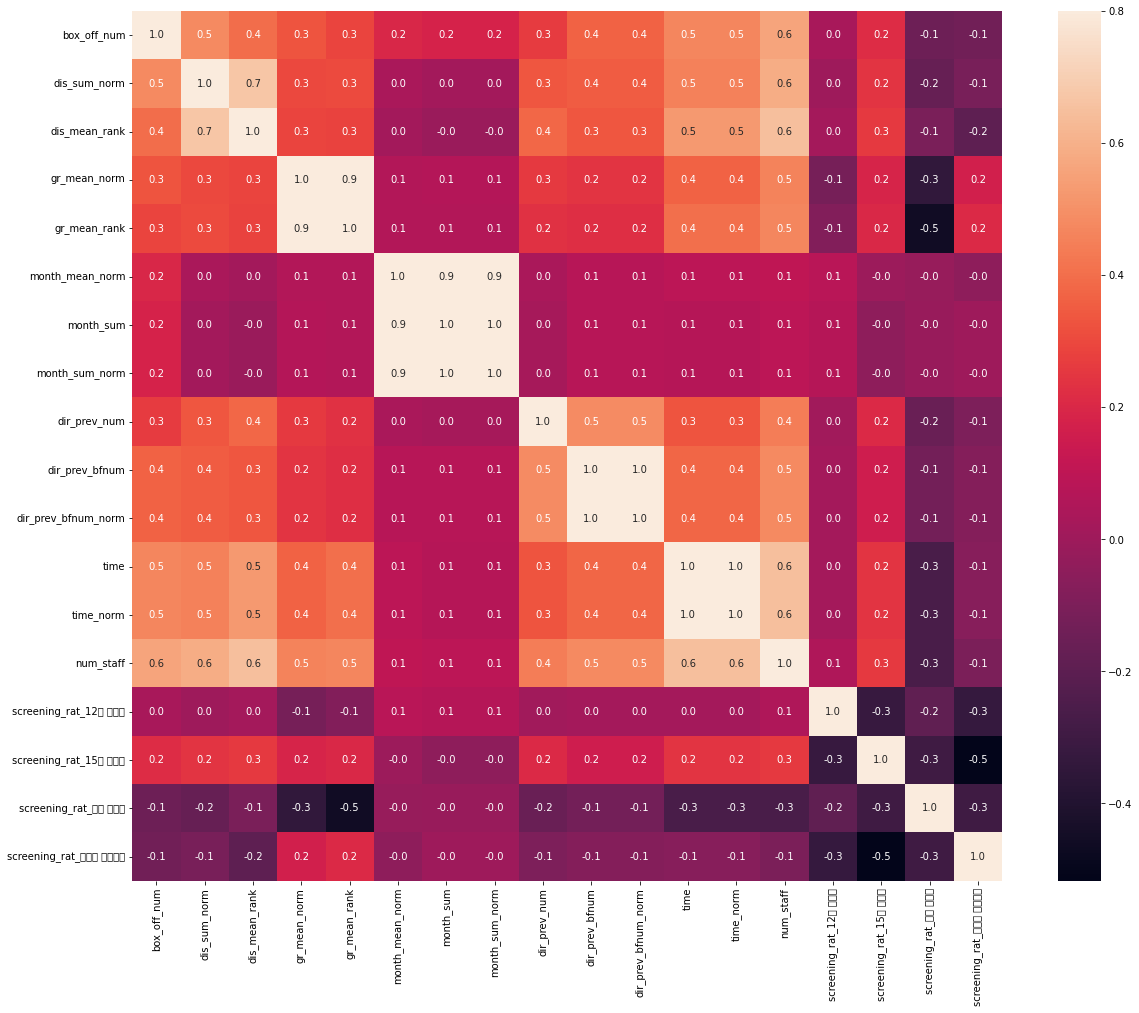

In [168]:
def draw_corrmat(df):
  y_corrmat = df.corr()
  f, ax = plt.subplots(figsize=(20,16))
  sns.heatmap(y_corrmat, vmax=.8, annot=True, fmt='.1f', square=True);
  
draw_corrmat(X)

# 교차 검증 10 Fold

In [139]:
from sklearn.model_selection import KFold

kf = KFold(n_splits =  10, shuffle = True, random_state = 42)

In [140]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from ngboost import NGBRegressor

In [144]:
gbm = GradientBoostingRegressor(random_state = 42)

rmse_list = []
gb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    gbm.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in gbm.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in gbm.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    gb_pred += (sub_pred / 10)
    
np.mean(rmse_list)

1122913.3795107626

In [145]:
ngb = NGBRegressor(random_state = 518)

rmse_list = []
ngb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    ngb.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in ngb.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in ngb.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    ngb_pred += (sub_pred / 10)
    
np.mean(rmse_list)

[iter 0] loss=2.6121 val_loss=0.0000 scale=1.0000 norm=2.9398
[iter 100] loss=2.0139 val_loss=0.0000 scale=2.0000 norm=2.8401
[iter 200] loss=1.5554 val_loss=0.0000 scale=2.0000 norm=2.1282
[iter 300] loss=1.3701 val_loss=0.0000 scale=2.0000 norm=1.9961
[iter 400] loss=1.2748 val_loss=0.0000 scale=1.0000 norm=0.9625
[iter 0] loss=1.2771 val_loss=0.0000 scale=1.0000 norm=1.0002
[iter 100] loss=1.2079 val_loss=0.0000 scale=1.0000 norm=0.9454
[iter 200] loss=1.1758 val_loss=0.0000 scale=1.0000 norm=0.9269
[iter 300] loss=1.1330 val_loss=0.0000 scale=1.0000 norm=0.9062
[iter 400] loss=1.0965 val_loss=0.0000 scale=0.5000 norm=0.4454
[iter 0] loss=1.2141 val_loss=0.0000 scale=1.0000 norm=0.9931
[iter 100] loss=1.0823 val_loss=0.0000 scale=1.0000 norm=0.8762
[iter 200] loss=1.0503 val_loss=0.0000 scale=2.0000 norm=1.7206
[iter 300] loss=1.0138 val_loss=0.0000 scale=0.5000 norm=0.4211
[iter 400] loss=0.9822 val_loss=0.0000 scale=1.0000 norm=0.8289
[iter 0] loss=0.9921 val_loss=0.0000 scale=0.5

1177456.8236650869

# lgbm 가장 예측력이 좋았음

In [208]:
lgbm = LGBMRegressor(random_state = 518)

rmse_list = []
lgb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    lgbm.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    lgb_pred += (sub_pred / 10)
    
np.mean(rmse_list)

1178129.1862135793

# xgb 그 다음으로 좋았음

In [209]:
xgb = XGBRegressor(random_state = 518)

rmse_list = []
xgb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    xgb.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in xgb.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in xgb.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    xgb_pred += (sub_pred / 10)
    
np.mean(rmse_list)

1246413.8356501558

In [148]:
cat = CatBoostRegressor(random_state = 518, silent = True)

rmse_list = []
cat_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    cat.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in cat.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in cat.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    cat_pred += (sub_pred / 10)
    
np.mean(rmse_list)

1166766.1923800795

In [149]:
rf = RandomForestRegressor(random_state = 518)

rmse_list = []
rf_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    rf.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in rf.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in rf.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    rf_pred += (sub_pred / 10)
    
np.mean(rmse_list)

952993.0520586999

In [211]:
submission = pd.read_csv('submission.csv')
#submission['box_off_num'] = (xgb_pred + lgb_pred) / 2
#submission['box_off_num'] = xgb_pred
submission['box_off_num'] = lgb_pred
submission.sort_values(by = 'box_off_num')

,title,box_off_num
173,옹녀뎐,1.111537e+02
130,댄서김의 은밀한 교수법,1.168678e+02
46,은어,1.297110e+02
39,REC 알이씨,1.389978e+02
49,겨울냄새,1.407461e+02
...,...,...
229,베테랑,5.315760e+06
106,댄싱퀸,5.415464e+06
179,군도: 민란의 시대,5.514046e+06
142,박수건달,6.971277e+06


In [212]:
submission.to_csv('team2_movies_13.csv', index = False)

In [213]:
from dacon_submit_api import dacon_submit_api 

result = dacon_submit_api.post_submission_file(
'team2_movies_13.csv', 
'61bbe3d0a7cc90dea2a88fe1a617507b8b597f9bdb5e200bb3a039208649ae7d', 
'235536', 
'수키', 
'RandomForestRegressor' )

{'isSubmitted': True, 'detail': 'Success'}
